In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')  # import bread
sys.path.append('../../experiment_gnn')  # import bread_nn
import bread.data, bread.vis
import bread_nn.graph
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import numpy as np
import torch_geometric

In [3]:
img_seg1 = bread.data.utils.load_npz('../../data/segmentations/colony007/030.npz')
img_vis1 = bread.data.utils.load_npz('../../data/microscopy_PhC/colony007/030.npz')
img_seg2 = bread.data.utils.load_npz('../../data/segmentations/colony007/040.npz')
img_vis2 = bread.data.utils.load_npz('../../data/microscopy_PhC/colony007/040.npz')

In [4]:
bbox = ((100, 320), (400, 190))

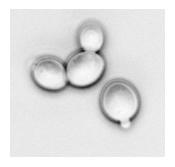

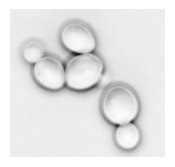

In [5]:
for img_vis, filename in ((img_vis1, 'example_vis1.png'), (img_vis2, 'example_vis2.png')):
	fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
	ax.set_xlim(bbox[0])
	ax.set_ylim(bbox[1])
	ax.set_axis_off()
	bread.vis.plot_visible(img_vis, figax=(fig, ax))
	fig.savefig(filename, pad_inches=0, bbox_inches='tight')

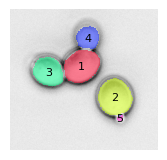

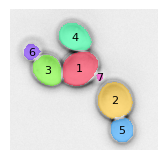

In [6]:
for img_vis, img_seg, filename in ((img_vis1, img_seg1, 'example_seg1.png'), (img_vis2, img_seg2, 'example_seg2.png')):
	fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
	bread.vis.plot_visible(img_vis, figax=(fig, ax))
	bread.vis.plot_seg(img_seg, figax=(fig, ax), alpha=0.5)
	ax.set_xlim(bbox[0])
	ax.set_ylim(bbox[1])
	ax.set_axis_off()
	fig.savefig(filename, pad_inches=0, bbox_inches='tight')

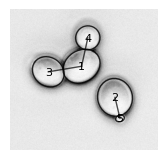

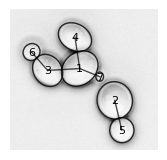

In [7]:
graph1, df_x1, df_e1 = bread_nn.graph.build_cellgraph(img_seg1, max_membdist=6, return_df=True)
graph2, df_x2, df_e2 = bread_nn.graph.build_cellgraph(img_seg2, max_membdist=6, return_df=True)

for img_vis, img_seg, graph, df_x, df_e, filename in ((img_vis1, img_seg1, graph1, df_x1, df_e1, 'example_feat1.png'), (img_vis2, img_seg2, graph2, df_x2, df_e2, 'example_feat2.png')):
	fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
	bread.vis.plot_visible(img_vis, figax=(fig, ax))
	bread.vis.plot_seg(img_seg, figax=(fig, ax), alpha=0)
	bread.vis.plot_ellipsefits(img_seg, df_x.r_maj.to_numpy(), df_x.r_min.to_numpy(), df_x.alpha_maj.to_numpy(), figax=(fig, ax), draw_axes=False)
	bread.vis.plot_graph(img_seg, df_e.loc[:, ['cell_id1', 'cell_id2']].to_numpy(), figax=(fig, ax))
	ax.set_xlim(bbox[0])
	ax.set_ylim(bbox[1])
	ax.set_axis_off()
	fig.savefig(filename, pad_inches=0, bbox_inches='tight')

In [8]:
with pd.option_context('display.precision', 2):
	display(df_x1.loc[:, ['cell_id', 'A', 'r_equiv', 'e']].style.hide_index())
	display(df_x2.loc[:, ['cell_id', 'A', 'r_equiv', 'e']].style.hide_index())
	display(df_e1.loc[:, ['cell_id1', 'cell_id2', 'rho', 'theta', 'l']].style.hide_index())
	display(df_e2.loc[:, ['cell_id1', 'cell_id2', 'rho', 'theta', 'l']].style.hide_index())
	
# Take a screenshot, lol

cell_id,A,r_equiv,e
1,2154.50,26.22,0.58
2,2294.50,27.06,0.40
3,1648.00,22.99,0.51
4,1010.00,18.00,0.18
5,95.50,5.67,0.68


cell_id,A,r_equiv,e
1,2199.50,26.52,0.59
2,2312.00,27.17,0.34
3,1639.00,22.97,0.55
4,1612.00,22.72,0.66
5,1057.50,18.40,0.26
6,490.00,12.61,0.36
7,116.00,6.26,0.54


cell_id1,cell_id2,rho,theta,l
1,3,50.32,1.74,2.00
1,4,43.33,-0.22,1.00
2,5,32.15,-2.91,1.00


cell_id1,cell_id2,rho,theta,l
1,3,47.85,1.63,1.00
1,4,47.36,0.15,2.00
1,7,32.11,-1.96,2.00
2,5,45.59,-2.91,1.00
3,6,36.43,0.72,2.00


In [9]:
assgraph = bread_nn.graph.build_assignmentgraph(graph1, graph2)
assgraph_truth = bread_nn.graph.build_assignmentgraph_track(img_seg1, img_seg2)

In [10]:
def plot_ass(assgraph, graph1, graph2, img_seg1, img_seg2):
	node_color=['#0f0' if tracklink else '#f00' for tracklink in assgraph_truth.x]
	labels1 = dict((i, f'{i+1:d}') for i in range(graph1.num_nodes))
	labels2 = dict((i, f'{i+1:d}') for i in range(graph2.num_nodes))
	labelsA = dict(
		(
			np.ravel_multi_index(((i,), (a,)), (graph1.num_nodes, graph2.num_nodes))[0],
			labels1[i] + '-' + labels2[a]
		)
		for i, a in itertools.product(range(graph1.num_nodes), range(graph2.num_nodes))
	)

	edge_index_undir = torch_geometric.utils.to_undirected(assgraph.edge_index)
	graph_ = torch_geometric.data.Data(x=assgraph.x, edge_index=edge_index_undir)

	nx.draw_shell(torch_geometric.utils.to_networkx(graph_, to_undirected=True), labels=labelsA, node_color=node_color, node_size=100, font_size=8)
	
	return plt.gcf(), plt.gca()

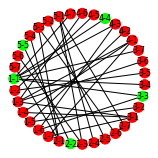

In [11]:
fig, ax = plot_ass(assgraph, graph1, graph2, img_seg1, img_seg2)
fig.set_size_inches((2, 2))
# ax.set_title('$\\mathcal{G}^{(a)}$', fontsize='xx-large')
plt.show(fig)
fig.savefig('example_assgraph.png', pad_inches=0, bbox_inches='tight', dpi=100)

In [12]:
from bread_nn.model import GNNNodeClassifier1
import torch

In [13]:
model = GNNNodeClassifier1.load_from_checkpoint('../../experiment_gnn/model_weights/colony0123_numframediff10/GNN_1_epoch271.ckpt')
model.eval()  # set to evaluation mode

GNNNodeClassifier1(
  (loss): CrossEntropyLoss()
  (node_encoder): MLP(6, 80, 80, 80)
  (edge_encoder): MLP(6, 80, 80, 80)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
    (4): DeepGCNLayer(block=res+)
    (5): DeepGCNLayer(block=res+)
  )
  (lin): Linear(in_features=80, out_features=2, bias=True)
)

In [14]:
model.predict(assgraph).reshape(graph1.num_nodes, graph2.num_nodes)

tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]])

In [15]:
cellgraphs = bread.data.utils.load_npz(glob('../../experiment_gnn/data/cellgraphs/colony00[0123]/*.npz'))

In [42]:
x_all = np.vstack(list(g['x'] for g in cellgraphs))
e_all = np.vstack(list(g['edge_attr'] for g in cellgraphs))
scale = 1/9.2308  # microns per pixel
x_all[:, 0] *= scale**2
x_all[:, 1] *= scale
e_all[:, 0] *= scale
e_all[:, 2] *= scale

In [33]:
scale*12

1.299995666681111

In [43]:
np.array([len(g['x']) for g in bread.data.utils.load_npz(glob('../../experiment_gnn/data/cellgraphs/colony00[0123]/179.npz'))]).mean()

109.5

In [55]:
180*4

720

In [56]:
np.array([len(g['x']) for g in bread.data.utils.load_npz(glob('../../experiment_gnn/data/cellgraphs/colony00[0123]/179.npz'))]).mean()

109.5

In [45]:
len(x_all), len(e_all)

(25510, 48018)

In [46]:
from uncertainties import ufloat

21+/-14
2.5+/-0.8
0.52+/-0.14


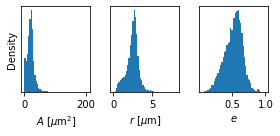

In [47]:
df_x_all = pd.DataFrame(x_all)
ax = df_x_all.hist(layout=(1, 3), figsize=(4, 2), grid=False, bins=50, density=True).flat
ax[0].set_xlabel('$A$ [$\mu$m$^2$]')
ax[1].set_xlabel('$r$ [$\mu$m]')
ax[2].set_xlabel('$e$')
ax[0].set_ylabel('Density')
ax[0].set_title('')
ax[1].set_title('')
ax[2].set_title('')
for i, a in enumerate(ax):
	a.yaxis.set_major_locator(plt.NullLocator())
	m = x_all[:, i].mean()
	s = x_all[:, i].std()
	print(ufloat(m, s))
fig = ax[0].figure
fig.tight_layout()
fig.savefig('hist_x.pdf')
plt.show()

In [48]:
df_x.iloc[:, 0].mean()

4.0

5.4+/-1.2
-0.0+/-1.8
0.34+/-0.22


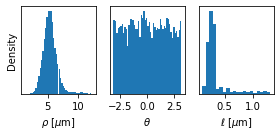

In [49]:
df_e_all = pd.DataFrame(e_all)
fig, ax = plt.subplots(ncols=3, figsize=(4, 2))
df_e_all.iloc[:, 0].hist(ax=ax[0], bins=50, density=True, grid=False)
df_e_all.iloc[:, 1].hist(ax=ax[1], bins=50, density=True, grid=False)
df_e_all.iloc[:, 2].hist(ax=ax[2], bins=20, density=True, grid=False)
ax[0].set_xlabel(r'$\rho$ [$\mu$m]')
ax[1].set_xlabel(r'$\theta$')
ax[2].set_xlabel(r'$\ell$ [$\mu$m]')
ax[0].set_ylabel('Density')
ax[0].set_title('')
ax[1].set_title('')
ax[2].set_title('')
for i, a in enumerate(ax):
	a.yaxis.set_major_locator(plt.NullLocator())
	m = e_all[:, i].mean()
	s = e_all[:, i].std()
	print(ufloat(m, s))
fig.tight_layout()
fig.savefig('hist_e.pdf')
plt.show()